In [1]:
# Mount your google drive as the data drive
# This will require google authorization
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical

import math
import os
import datetime
import csv
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

# from tqdm import tqdm_notebook as tqdm
import tqdm

import time

from IPython import display

import urllib.request

Using TensorFlow backend.


# Args

In [0]:
# The Args object will contain all of our parameters
# If you want to run with different arguments, create another Args object

class Args(object):
    def __init__(self, name='PointerNet_tsp5', 
        save_dir='drive/My Drive/Colab Notebooks/discrete_opti_final/models/',
        batch_size=64, test_batch_size=1000, epochs=10, lr=1e-3, 
        optimizer='adam', log_interval=500, model='Seq2Seq', 
        n=5, dataset='tsp5.txt', testset='tsp5_test.txt',
        data_dir='drive/My Drive/Colab Notebooks/discrete_opti_final/tsp/', 
        split=0.2, seed=1, shuffle=True, cuda=True, emb_dim=256, hid_dim=512, 
        n_layers=1, save=True,
        csv_outfile='drive/My Drive/Colab Notebooks/discrete_opti_final/csv/',
        loss='cce', dropout=0, bidir=False):
        
        """
        name - used to name the saved model - dont use spaces
        batch_size - input batch size for training
        test_batch_size - input batch size for testing
        epochs - the number of epochs to train
        lr - learning rate
        optimizer - adam, rms_prop,
        log_interval - batches to wait before logging detailed status. 0 = never
        model - the name of the model to train:
            PointerNet, 
        n - the number of cities
        dataset - the file name of the dataset to load: 
            tsp5.txt, tsp_10_train_exact.txt, 
        testset - the file name of the testset to load:
            tsp5_test, tsp_10_test_exact.txt
        data_dir - the directory of the datasets. 
            All data is assumed to be in the same directory.
        split - the amount to split the training data into a validation set. 
            A number between [0, 1]. 0 = none
        seed - the seed for the random number generator.Uused to split the
            dataset into a train and val set.
        shuffle - shuffle the dataset or not
        cuda - tells if you want to train on gpu or not
        """
        
        self.name = name
        self.save_dir = save_dir
        
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size 
        self.epochs = epochs 
        self.lr = lr 
        self.optimizer = optimizer
        
        self.log_interval = log_interval 
        
        self.model = model
                   
        self.n = n
        self.dataset = dataset 
        self.testset = testset
        self.data_dir = data_dir
        self.split = split
        self.seed = seed
        self.shuffle = shuffle
        
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
                 
        self.csv_outfile = csv_outfile
        self.save = save
        
        self.loss = loss
        
        self.dropout = dropout
        self.bidir = bidir
        
        self.cuda = cuda and torch.cuda.is_available()

# Prepare Data

Create a dataloader so pytorch takes care of transforming it to tensors and so we can use the pytorch iterators.

In [0]:
class TSP_dataset(Dataset):
    def __init__(self, path, n):
        """
        Reads in the dataset and stores it in the dataset object
        The TSP dataset is m examples stored in csv files with the format:
        x1 y1 ... xn yn output 1 ... n ... 1 
        The x data is just a [m,n,2] matrix of x, y points 
        The labels are a [m,n,1] matrix of cities
        """
        df = pd.read_csv(path, delimiter=' ', header=None)
        df = df.dropna(axis=1)
        
        self.n = n
        self.x = torch.from_numpy(df[range(0, n*2)].values.reshape(
            (len(df[range(0, n*2)].values), n, 2))).float()
        # subtract 1 from the points read in because the cities are 1 indexed
        #self.labels = to_categorical(df[range(n*2+1, n*3+2)].values - 1)
        self.labels = torch.from_numpy(df[range(n*2+1, n*3+1)].values - 1).long()
        
    def __len__(self):
        """
        returns the size of the input data
        """
        return len(self.x)
    
    def __getitem__(self, index):
        """
        Tells Pytorch how to generate one sample of the data
        It generates a [n,2] example and a [n,1] target
        """
        return self.x[index], self.labels[index]

In [0]:
def prepare_dataset(args, num_workers=4, onehot=False):
    
    # create an instance of the tsp dataset
    if onehot:
        tsp = TSP_dataset_onehot(args.data_dir + args.dataset, args.n)
    else:
        tsp = TSP_dataset(args.data_dir + args.dataset, args.n)
    
    # Creating data indices for training and validation splits:
    dataset_size = len(tsp)
    indices = list(range(dataset_size))
    split = int(np.floor(args.split * dataset_size))
    # shuffle the data
    if args.shuffle:
        np.random.seed(args.seed)
        np.random.shuffle(indices)
    # get the indicies
    train_indices, val_indices = indices[split:], indices[:split]
    
    # create the samplers
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    
    # create the dataloaders
    train_loader = DataLoader(tsp, batch_size=args.batch_size, 
                              sampler=train_sampler, num_workers=num_workers)
    val_loader = DataLoader(tsp, batch_size=args.batch_size,
                             sampler=valid_sampler, num_workers=num_workers)
    test_loader = DataLoader(TSP_dataset(args.data_dir + args.testset, args.n),
                             batch_size=args.test_batch_size, 
                             shuffle=args.shuffle, num_workers=num_workers)
    
    return train_loader, val_loader, test_loader
    

## Test the loader

In [0]:
args = Args(batch_size=128, epochs=5)

In [0]:
train_loader, val_loader, test_loader = prepare_dataset(args, num_workers=4)

In [0]:
# for i, (data, target) in enumerate(train_loader):
#     if i < 1:
#         print(data.shape)
#         print(target.shape)
#     break

torch.Size([128, 5, 2])
torch.Size([128, 5])


In [0]:
# for i, (data, target) in enumerate(train_loader):
#     if i < 1:
#         print(data[0])
#         print(target[0])

tensor([[0.8420, 0.1505],
        [0.9781, 0.5147],
        [0.4958, 0.9906],
        [0.5535, 0.7589],
        [0.7142, 0.2145]])
tensor([0, 1, 2, 3, 4])


# TSP cost calculation

In [0]:
def contains_duplicates(X):
    return len(torch.unique(X)) != len(X)

In [0]:
def tsp_cost(data, target):
    """
    data - a [input size, N, 2] array - each of the batch_size number of 
        matrices is a array of [N, 2] (x, y) points
    order - [input size, N] - the order of points to travel - not one-hot encoded
    returns all individual costs and the average tsp_cost
    only considers valid tours
    """
    
    # get the order that the path is
    all_costs = []
    count = 0
    for d, t in zip(data, target):
        
        # only if tour is valid
        if contains_duplicates(t):
            continue
            
        path = d[t]
        
        # now loop through the path and get the tsp cost
        path_cost = 0
        prev = first = path[0]
        for curr in path:
            path_cost += torch.norm(prev - curr)
            prev = curr
        
        path_cost += torch.norm(prev - first)
        all_costs.append(path_cost)
        count += 1
        
    all_costs = torch.stack(all_costs)
        
    return all_costs, torch.mean(all_costs), count

In [0]:
def tsp_cost_train(data, target):
    """
    data - a [input size, N, 2] array - each of the batch_size number of 
        matrices is a array of [N, 2] (x, y) points
    order - [input size, N] - the order of points to travel - not one-hot encoded
    returns all individual costs and the average tsp_cost
    for training allows for invalid tours
    """
    
    # get the order that the path is
    all_costs = Variable(torch.zeros((data.size(0),), requires_grad=True))
    for i, (d, t) in enumerate(zip(data, target)):
        
        path = d[t]
        
        # now loop through the path and get the tsp cost
        prev = path[0]
        for curr in path:
            all_costs[i] += torch.norm(prev - curr)
            prev = curr
        
        all_costs[i] += torch.norm(prev - path[0])
        
        
    return all_costs

## Get the mean cost of optimal

In [0]:
# means = []
# for data, target in train_loader:
    
#     _, m = tsp_cost(data, target)
#     means.append(m)
    
# torch.mean(torch.stack(means))

# # tensor(2.1262)
          

tensor(2.1262)

In [0]:
# _, m = tsp_cost(data, target)
# print(m)

# # tensor(2.1880)

tensor(2.1880)


# Models

## Encoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout=0, bidir=False):
        super(Encoder, self).__init__()
        """
        emb_dim - the dimensionality of the embedding layer. 
        hid_dim - the dimensionality of the hidden and cell states.
            Should be the same as the Decoder's hidden state
        n_layers - the number of layers in the RNN
            Should be the same as the n_layers of the Decoder
        dropout - the amount of dropout to use - only use if n_layers > 1
        bidir - if we want a bidirectional RNN or not
        """
        
        
        self.emb_dim = emb_dim 
        self.hid_dim = hid_dim // 2 if bidir else hid_dim
        self.n_layers = n_layers * 2 if bidir else n_layers
        self.bidir = bidir
        self.dp = dropout
        
        # used as the first hidden and cell states
        self.h0 = Parameter(torch.zeros(1), requires_grad=False)
        self.c0 = Parameter(torch.zeros(1), requires_grad=False)
        
        # we are putting in (x, y) pairs as the input
        # learns the dense representation of the data
        # TODO: MOVE THIS INTO SEQTOSEQ
#         self.embedding = nn.Linear(2, emb_dim)
        
        # the RNN itself
        self.rnn = nn.LSTM(emb_dim, self.hid_dim, n_layers, dropout=dropout, bidirectional=bidir)

    def forward(self, input, hidden, cell):
        """
        input - the embedded data, the dense representation of data
            it has a shape of [batch size, n, emb dim]
        hidden - the previous hidden state for the RNN
            shape: [n layers, batch size, hid dim]
        cell - the previous cell state for the RNN
            shape: [n layers, batch size, hid dim]
        """
        
        # get the output of the embedding then permute change the dims of the 
        # embedded = [n, batch size, emb dim]
        embedded = input.permute(1, 0, 2)
        
        # get the output from the RNN
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        # outputs before permute = [n, batch size, hid dim]
        # outputs after permute = [batch size, n, hid dim]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]
        
        return output.permute(1,0,2), hidden, cell

    def init_hidden(self, embedded_inputs):
        # turn the size [1] h0 vec into [1, 1, 1] vec by unsqueezeing it
        # then turn it into a [n layers, batch size, hid dim] vec of 0's
        
        batch_size = embedded_inputs.size(0)
        
        h0 = self.h0.unsqueeze(0).unsqueeze(0).repeat(self.n_layers,
                                                      batch_size,
                                                      self.hid_dim)
        c0 = self.c0.unsqueeze(0).unsqueeze(0).repeat(self.n_layers,
                                                      batch_size,
                                                      self.hid_dim)
        return h0, c0

## Attention

In [0]:
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        """
        input_dim - the dimensionality of the input.
            Should be the same size as the Encoder and Decoder's hidden size
        """
        
        self.input_dim = input_dim
        
        # to calculate the attention vector: 
        # u = V.T * tanh(W1*e + W2*d)
        # then use softmax to get probabilities
        # p(Ci|Ci, ... ,Ci - 1, P) = softmax(u)
        # v, W1, W2, are learnable parameters
        # e is the encoder state - the context vector - from the encoder
        # d is the decoder state - the hidden state of the decoder
        self.W1 = nn.Linear(self.input_dim, self.input_dim, bias=False)
        self.W2 = nn.Linear(self.input_dim, self.input_dim, bias=False)
        self.V = nn.Parameter(torch.FloatTensor(self.input_dim), requires_grad=True)
        
        self.tanh = nn.Tanh()
    
    def forward(self, enc_output, hidden, mask=None):
        """
        enc_output - the encoder's output 
            size: [batch size, n, hid dim]
        hidden - the decoder's hidden state
            size: [n layers, batch size, hid dim]
        """
        
        # the weights on the encoders output 
        # outputs a [batch size, n, hid dim] tensor
        # thst is permuted to a [batch size, hid dim, n] tensor
        e = self.W1(enc_output).permute(0,2,1)
        
        # the weights on the decoders hidden state
        # outputs a [batch size, hid dim, 1] tensor
        d = self.W2(hidden).permute(1,2,0)
        
        # V.T * tanh(W1*e + W2*d)
        # outputs a [batch size, hid dim, n] tensor
        summed = self.tanh(e + d)
        
        # outputs a [batch, 1, hid dim] tensor
        V = self.V.unsqueeze(0).expand(summed.size(0), -1).unsqueeze(1)
        
        # multiplies V.T and tanh(W1*e + W2*d) 
        # bmm is batch matrix-matrix product of matrices
        # it matrix multiplies the whole batch
        # bmm outputs a [batch size, 1, n] tensor
        # we get rid of the second dim and reshape it to [batch size, n]
        u = torch.bmm(V, summed).squeeze(1)
        
        # softmax(u) - calculate it so all examples sums to 1
        # outputs a [batch size, n] tensor of attention weights
        # this is our pointers
        attn_weights = F.softmax(u, dim=1).unsqueeze(1)
        
        # IF ADD MASK ADD HERE

        # now combine the encoder outputs and the weights to get how much
        # attention to pay to each of the encoded inputs - the context
        # size after squeeze: [batch size, hid dim]
        context = attn_weights.bmm(enc_output)
    
        # return 
        # attn_weight [batch size, 1, n] tensor
        # context [batch size, 1, hid dim] tensor
        return attn_weights, context

## Decoder

In [0]:
class Decoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout=0):
        super(Decoder, self).__init__()
        """
        emb_dim - the dimensionality of the embedding layer. 
        hid_dim - the dimensionality of the hidden and cell states.
            Should be the same as the Encoder's hidden state
        n_layers - is the number of layers in the RNN.
        dropout - is the amount of dropout to use. 
            This is a regularization parameter to prevent overfitting
        """
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dp = dropout
        
        self.embedding = nn.Linear(2, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim + hid_dim, hid_dim, n_layers, dropout = dropout)
        
        self.attention = Attention(hid_dim)
        
    def forward(self, input, input0, enc_output, hidden, cell):
        """
        input - the batch of encoded data. size [batch size, n, emb dim]
        input0 - the decoder's first input. size [1, batch, emb dim]
        enc_output - the output from the encoder [batch, n, hidden]
        hidden - hidden state to LSTM. size [n layers, batch size, hid dim]
        cell - cell state to LSTM. size [n layers, batch size, hid dim]
        Initial hidden and cell states are the hidden and cell states of 
        our encoder from the same layer (if the LSTM has more than 1 layer)
        """
        
        outputs = []
        pointers = []
        
        # the first input
        word_emb = input0
        
        # now we have to loop through the sequence length, n, and feed it into
        # the RNN. Each "word", embedded[i], will be size [emb dim, hid dim]
        for i in range(input.size(1)):
            
            # we get the attn_weight and context vectors
            # the initial hidden is from the encoder hidden state
            # attn_weight [batch size, 1, n]
            # context [batch size, 1, hid dim]
            attn_weight, context = self.attention(enc_output, hidden)

            # now we combine the context vec with with embedded word vec
            context = context.transpose(0, 1) # [1, batch, hid dim]
            combined = torch.cat((word_emb, context), 2) 
            # [1, batch, emb dim + hid dim]
            
            # feed into the RNN the combined input and attended context
            # input needs to be size: [1, batch size, emb dim + hid dim]
            # output = [1, batch size, hid dim]
            # hidden = [n layers, batch size, hid dim]
            # cell = [n layers, batch size, hid dim]
            output, (hidden, cell) = self.rnn(combined, (hidden, cell))
            
            # Now predict where the pointer is pointing to by looking at the
            # attention weight
            probs, idx = attn_weight.max(2)
            # get [batch, 1] tensors of max probs and idx
            
            # OVER HERE WOULD BE WHERE TO UPDATE A MASK
            
            # get the next embedded words based on max index by looping through
            # the indicies array and for each batch, get the max indexed
            # embedded input
            # OVER HERE WOULD BE WHERE TO DO RANDOMLY DECIDE IF PUTTING IN THE
            # TARGET INSTEAD OF PREDICTED
            word_emb = input[:, idx.squeeze(), :].diagonal().transpose(1,0).unsqueeze(0)
            
            # Append the attention weights and the max idx to outputs and 
            # pointers, respectively
            outputs.append(attn_weight.squeeze())
            pointers.append(idx.squeeze())
        
        # return 
        # outputs: [batch size, N, N] # the probabilities itself
        # pointers: [batch size, N] # the pointers - argmexed probabilities
        # hidden: [n layers, batch size, hidden dim]
        # cell: [n layers, batch size, hid dim]
        return torch.stack(outputs,1), torch.stack(pointers,1), hidden, cell
    

## Seq2Seq

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout=0, bidir=False):
        super(Seq2Seq, self).__init__()
        """
        emb_dim - the dimensionality of the embedding layer. 
        hid_dim - the dimensionality of the hidden and cell states.
        n_layers - is the number of layers in the RNN.
        dropout - is the amount of dropout to use. 
            This is a regularization parameter to prevent overfitting
        """
        
        self.bidir = bidir
        
        self.embedding = nn.Linear(2, emb_dim)
        
        self.encoder = Encoder(emb_dim=emb_dim, hid_dim=hid_dim, n_layers=n_layers, dropout=dropout, bidir=bidir)
        
        self.decoder = Decoder(emb_dim=emb_dim, hid_dim=hid_dim, n_layers=n_layers, dropout=dropout)
        
        
    def forward(self, src):
        
        #src = [batch size, N, 2]
        
        # calculate embedded inputs
        embedded = self.embedding(src)
        
        # get the initial hidden states 
        h0, c0 = self.encoder.init_hidden(embedded)
        
        # encoder
        oe, he, ce = self.encoder(embedded, h0, c0)
        
        # decoder
        if self.bidir:
            he = torch.cat((he[0], he[1]), -1).unsqueeze(0)
            ce = torch.cat((ce[0], ce[1]), -1).unsqueeze(0)
            
        output, pointers, hd, cd = self.decoder(embedded, embedded.permute(1, 0, 2)[0].unsqueeze(0), oe, he, ce)
        
        return output, pointers

# Train and Test

## CCE Loss

In [0]:
def train(model, optimizer, train_loader, epoch, total_minibatch_count, 
          train_losses, train_accs, train_tour, args):
    
    # set model to train mode
    model.train()
    CCE = torch.nn.CrossEntropyLoss()
    
    correct_count, total_loss, total_acc = 0., 0., 0.
    progress_bar = tqdm.tqdm(train_loader, desc='Training')
    
    for batch_idx, (data, target) in enumerate(progress_bar):
    
        if args.cuda:
            data, target = data.cuda(), target.cuda()

        # Forward prediction step
        output, pointers = model(data)
        loss = CCE(output, target)
        
        # reset the optimizer's gradient to 0 from the prev batch
        optimizer.zero_grad()
        # Backpropagation step
        loss.backward()
        optimizer.step()

        # target labels and predictions are categorical values from 0 to 9.
        matches = target == pointers
        accuracy = matches.float().mean()
#         correct_count += matches.sum()

        if args.log_interval != 0 and \
                total_minibatch_count % args.log_interval == 0:

            train_losses.append(loss.item())
            train_accs.append(accuracy.item())
        

        total_loss += loss.data
        total_acc += accuracy.data

        progress_bar.set_description(
            'Epoch {}: Loss: {:.4f}, Acc: {:.2f}'.format(
                epoch, total_loss / (batch_idx + 1), total_acc / (batch_idx + 1)))
        #progress_bar.refresh()

        total_minibatch_count += 1

    return total_minibatch_count

In [0]:
def test(model, test_loader, epoch, total_minibatch_count,
        val_losses, val_accs, val_tour, args, test_size):
    
    CCE = torch.nn.CrossEntropyLoss(reduction='sum')
    
    # Validation Testing
    model.eval()
    test_loss, correct = 0., 0.
    progress_bar = tqdm.tqdm(test_loader, desc='Validation')
    with torch.no_grad():
        for data, target in progress_bar:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            output, pointers = model(data)
            test_loss += CCE(output, target).item()  # sum up batch loss
            correct += (target == pointers).float().sum()

    test_loss /= (test_size * args.n)
    
    acc = correct / (test_size * args.n)

    val_losses.append(test_loss)
    val_accs.append(acc)
    
    progress_bar.clear()
    progress_bar.write(
        'validation test results - Loss: {:.4f}, Acc: {}/{} ({:.2f}%)'.format(
            test_loss, correct, (test_size * args.n),
            100. * correct / (test_size * args.n)))

    return acc

## Init Weights

In [0]:
# init weights - in Pytorch they are auto initiated
# however, in the tutorial, which folows hte paper, they init
# the weights uniformly between [-0.08, 0.08]
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

## Train and Test with MSE Loss

In [0]:
def train_mse(model, optimizer, train_loader, epoch, total_minibatch_count, 
          train_losses, train_accs, train_tour, args):
    
    # set model to train mode
    model.train()
    
    print("Epoch:", epoch)
    
    correct_count, total_loss, total_acc = 0., 0., 0.
    progress_bar = tqdm(train_loader, desc='Training')
    
    for batch_idx, (data, target) in enumerate(progress_bar):
    
        if args.cuda:
            data, target = data.cuda(), target.cuda()

        # Forward prediction step
        output, pointers = model(data)
        
        # calculate the tour length
        opt = tsp_cost_train(data, target)
        aprox = tsp_cost_train(data, pointers)
        
        loss = F.mse_loss(aprox, opt)
        
        # reset the optimizer's gradient to 0 from the prev batch
        optimizer.zero_grad()
        # Backpropagation step
        loss.backward()
        optimizer.step()

        # target labels and predictions are categorical values from 0 to 9.
        matches = target == pointers
        accuracy = matches.float().mean()
#         correct_count += matches.sum()

        if args.log_interval != 0 and \
                total_minibatch_count % args.log_interval == 0:

            train_losses.append(loss.item())
            train_accs.append(accuracy.item())
        

        total_loss += loss.data
        total_acc += accuracy.data

        progress_bar.set_description(
            '{:.4f} {:.2f}'.format(
                total_loss / (batch_idx + 1), total_acc / (batch_idx + 1)))
        #progress_bar.refresh()

        total_minibatch_count += 1

    return total_minibatch_count

In [0]:
def test_mse(model, test_loader, epoch, total_minibatch_count,
        val_losses, val_accs, val_tour, args):
    
    CCE = torch.nn.CrossEntropyLoss(reduction='sum')
    
    # Validation Testing
    model.eval()
    test_loss, correct = 0., 0.
    progress_bar = tqdm(test_loader, desc='Validation')
    with torch.no_grad():
        for data, target in progress_bar:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            output, pointers = model(data)
            
            # calculate the tour length
            opt = tsp_cost_train(data, target)
            aprox = tsp_cost_train(data, pointers)
            
            test_loss += F.mse_loss(output, target).item()  # sum up batch loss
            correct += (target == pointers).float().sum()

    test_loss /= (len(test_loader.dataset))
    
    acc = correct / (len(test_loader.dataset) * args.n)

    val_losses.append(test_loss)
    val_accs.append(acc)
    
    progress_bar.clear()
    progress_bar.write(
        '\nEpoch: {} validation test results - Average val_loss: {:.4f}, val_acc: {}/{} ({:.2f}%)'.format(
            epoch, test_loss, correct, len(test_loader.dataset),
            100. * correct / (len(test_loader.dataset) * args.n)))

    return acc

## Run

In [0]:
# Run the experiment
def run_experiment(args):

    total_minibatch_count = 0

    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    train_loader, val_loader, test_loader = prepare_dataset(args, num_workers=4)

    epochs_to_run = args.epochs

    # Choose model
    # TODO add all the other models here if their parameter is specified
    if args.model in globals():
        model = Seq2Seq(emb_dim=args.emb_dim, hid_dim=args.hid_dim, n_layers=args.n_layers, dropout=args.dropout, bidir=args.bidir)
    else:
        raise ValueError('Unknown model type: ' + args.model)

    if args.cuda:
        print('Using GPU, %i devices.' % torch.cuda.device_count())
        model.cuda()
        net = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
        cudnn.benchmark = True
     
    # initialize all the starting weights to be uniform [-0.8, 0.8]
    model.apply(init_weights)
    
    val_size = len(val_loader.dataset) * args.split

    # Choose optimizer
    if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    elif args.optimizer == 'adam':
        optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                                model.parameters()),
                         lr=args.lr)
    elif args.optimizer == 'rmsprop':
        optimizer = optim.RMSprop(filter(lambda p: p.requires_grad,
                                model.parameters()),
                         lr=args.lr)
    else:
        raise ValueError('Unsupported optimizer: ' + args.optimizer)

    # Run the primary training loop, starting with validation accuracy of 0
    val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    train_tour, val_tour = [], []

    # regular cce loss
    for epoch in range(1, epochs_to_run + 1):

        # train for 1 epoch
        total_minibatch_count = train(model, optimizer, train_loader,
                                    epoch, total_minibatch_count,
                                    train_losses, train_accs, train_tour, args)

        # validate progress on test dataset
        val_acc = test(model, val_loader, epoch, total_minibatch_count,
                       val_losses, val_accs, val_tour, args, val_size)
        
        
    fig, axes = plt.subplots(1,4, figsize=(20,4))
    # plot the losses and acc
    plt.title(args.name)
    axes[0].plot(train_losses)
    axes[0].set_title("Loss vs Steps")
    axes[0].set_xlabel("Number of backprop steps")
    axes[0].set_ylabel("Categorical Cross Entropy Loss")
    
    axes[1].plot(train_accs)
    axes[1].set_title("Acc vs Steps")
    axes[1].set_xlabel("Number of backprop steps")
    axes[1].set_ylabel("Categorical Accuracy")
    
    axes[2].plot(val_losses)
    axes[2].set_title("Val loss vs Steps")
    axes[2].set_xlabel("Number of epochs")
    axes[2].set_ylabel("Categorical Cross Entropy Loss")
    
    axes[3].plot(val_accs)
    axes[3].set_title("Val Acc vs Steps")
    axes[3].set_xlabel("Number of epochs")
    axes[3].set_ylabel("Categorical Accuracy")
    
    # Write to csv file
    with open(os.path.join(args.csv_outfile + args.name + 'train.csv'), 'w') as f:
        csvw = csv.writer(f, delimiter=',')
        for loss, acc in zip(train_losses, train_accs):
            csvw.writerow((loss, acc))
            
    with open(os.path.join(args.csv_outfile + args.name + 'val.csv'), 'w') as f:
        csvw = csv.writer(f, delimiter=',')
        for loss, acc in zip(val_losses, val_accs):
            csvw.writerow((loss, acc))
            
    # Save the entire model
    if args.save:
        path = os.path.join(args.save_dir + args.name + '.pt')
        print("Saving Model to: ", path)
        torch.save(model.state_dict(), path)

    # Predict and Test
#     images, labels = next(iter(val_loader))
#     if args.cuda:
#         images, labels = images.cuda(), labels.cuda()
#     output, pointers = model(images)
#     predicted = pointers
#     fig, axes = pl  t.subplots(1,6)
#     for i, (axis, img, lbl) in enumerate(zip(axes, images, predicted)):
#         if i > 5:
#             break
#         img = img.permute(1,2,0).squeeze()
#         axis.imshow(img)
#         axis.set_title(lbl.data)
#         axis.set_yticklabels([])
#         axis.set_xticklabels([])

    return model

# Run nets

Using GPU, 1 devices.


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

validation test results - Loss: 1.2248, Acc: 567592.0/1000000.0 (56.76%)


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

validation test results - Loss: 1.2139, Acc: 573661.0/1000000.0 (57.37%)


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

validation test results - Loss: 1.2111, Acc: 572305.0/1000000.0 (57.23%)


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

validation test results - Loss: 1.2106, Acc: 574946.0/1000000.0 (57.49%)


Validation: 100%|██████████| 3125/3125 [00:17<00:00, 175.09it/s]


validation test results - Loss: 1.2093, Acc: 574737.0/1000000.0 (57.47%)
Saving Model to:  drive/My Drive/Colab Notebooks/discrete_opti_final/models/rmsprop.pt


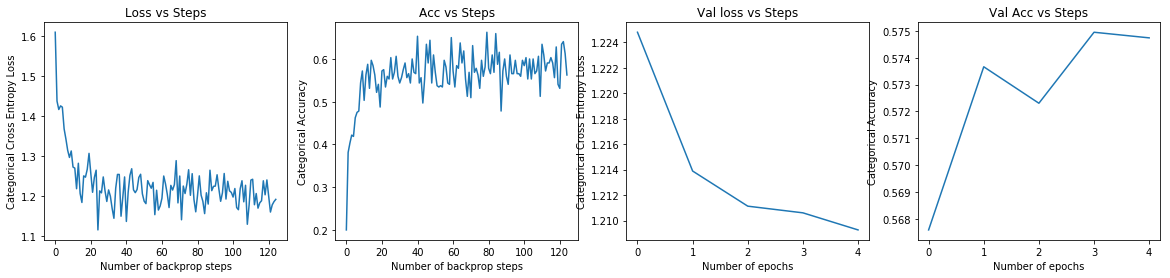

In [14]:
pointer1 = run_experiment(Args(name='rmsprop', epochs=5, optimizer='rmsprop'))

Using GPU, 1 devices.




Epoch: 1 validation test results - Average val_loss: 1.3542, val_acc: 23665.0/10000 (47.33%)




Epoch: 2 validation test results - Average val_loss: 1.3493, val_acc: 23362.0/10000 (46.72%)




Epoch: 3 validation test results - Average val_loss: 1.2353, val_acc: 28235.0/10000 (56.47%)




Epoch: 4 validation test results - Average val_loss: 1.2231, val_acc: 28246.0/10000 (56.49%)




Epoch: 5 validation test results - Average val_loss: 1.2174, val_acc: 28574.0/10000 (57.15%)
Saving Model to:  drive/My Drive/Colab Notebooks/discrete_opti_final/models/pointer_5epoch.pt


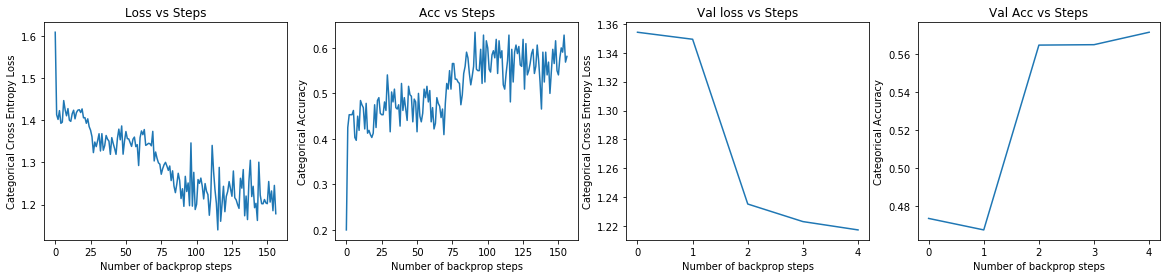

In [0]:
pointer2 = run_experiment(Args(name='pointer_5epoch', epochs=5))

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Using GPU, 1 devices.
Epoch: 1


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch 1: Loss: 1.4158, Acc: 435550.0/1000000.0 (43.56%)
Epoch: 2


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch 2: Loss: 1.3496, Acc: 467592.0/1000000.0 (46.76%)
Epoch: 3


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch 3: Loss: 1.2386, Acc: 561922.0/1000000.0 (56.19%)
Epoch: 4


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Epoch 4: Loss: 1.2253, Acc: 571619.0/1000000.0 (57.16%)
Epoch: 5


Validation: 100%|██████████| 3125/3125 [00:17<00:00, 177.76it/s]


Epoch 5: Loss: 1.2194, Acc: 568881.0/1000000.0 (56.89%)
Saving Model to:  drive/My Drive/Colab Notebooks/discrete_opti_final/models/eightnet.pt


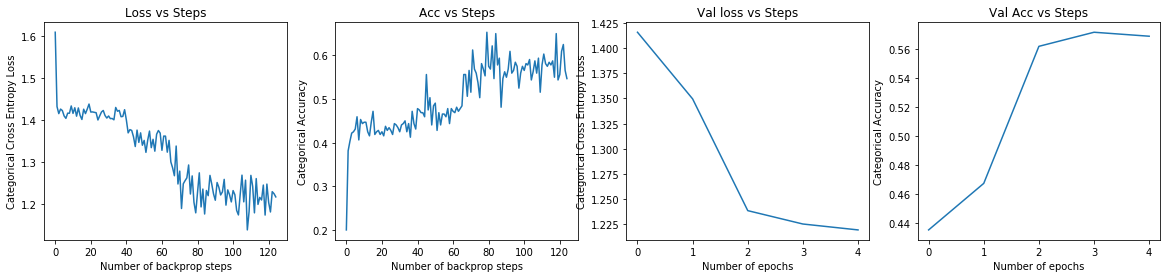

In [0]:
eightnet = run_experiment(Args(name='eightnet', epochs=5, log_interval=500))

Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Using GPU, 1 devices.


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

validation test results - Loss: 1.3480, Acc: 472774.0/1000000.0 (47.28%)


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

validation test results - Loss: 1.2243, Acc: 564680.0/1000000.0 (56.47%)


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

validation test results - Loss: 1.2166, Acc: 571014.0/1000000.0 (57.10%)


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

validation test results - Loss: 1.2138, Acc: 572289.0/1000000.0 (57.23%)


Validation: 100%|██████████| 3125/3125 [00:18<00:00, 166.43it/s]


validation test results - Loss: 1.2107, Acc: 572311.0/1000000.0 (57.23%)
Saving Model to:  drive/My Drive/Colab Notebooks/discrete_opti_final/models/bidir.pt


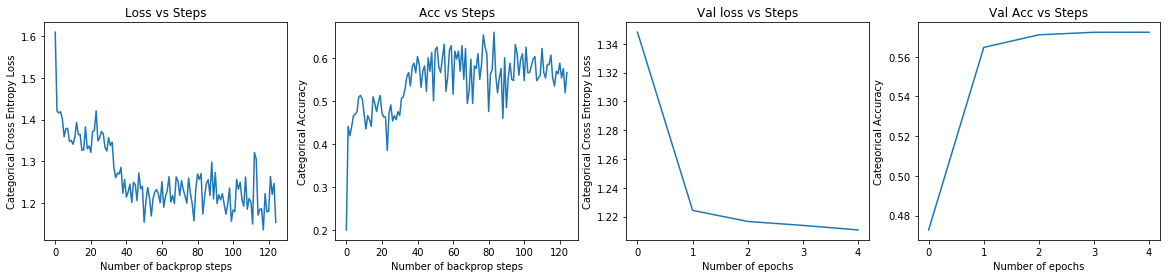

In [0]:
_ = run_experiment(Args(name='bidir', epochs=5, log_interval=500, bidir=True))

# Inference

In [0]:
def infer(dataloader, model, args):
    
    tour_len = []
    count = []
    model.eval()
    
    progress_bar = tqdm.tqdm(dataloader, desc='Inference')
    with torch.no_grad():
        for idx, (data, target) in enumerate(progress_bar):
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            _, pointers = model(data)
            
            # get the mean tour length
            _, mtl, cnt = tsp_cost(data, pointers)
            
            tour_len.append(mtl)
            count.append(cnt)
    
    return tour_len, count

In [0]:
args = Args(batch_size=100, epochs=5)
t, v, m = prepare_dataset(args, num_workers=4)

In [18]:
loaded = Seq2Seq(emb_dim=args.emb_dim, hid_dim=args.hid_dim, n_layers=args.n_layers, bidir=True)
loaded.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/discrete_opti_final/models/bidir.pt'))
loaded.cuda()

Seq2Seq(
  (embedding): Linear(in_features=2, out_features=256, bias=True)
  (encoder): Encoder(
    (rnn): LSTM(256, 256, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Linear(in_features=2, out_features=256, bias=True)
    (rnn): LSTM(768, 512)
    (attention): Attention(
      (W1): Linear(in_features=512, out_features=512, bias=False)
      (W2): Linear(in_features=512, out_features=512, bias=False)
      (tanh): Tanh()
    )
  )
)

In [24]:
tourt, countt = infer(t, loaded, args)

Inference: 100%|██████████| 8000/8000 [07:57<00:00, 16.74it/s]


In [0]:
print(tour)

tensor(2.3341, device='cuda:0')


In [0]:
a = torch.stack(tourt)
b = torch.tensor(countt)

In [0]:
print(b.float())

tensor([84., 86., 84.,  ..., 78., 80., 81.])


In [30]:
aprox_bidir = np.sum(a.cpu().numpy() * b.numpy()) / np.sum(b.numpy())
print(aprox_bidir)
print(aprox_bidir/opt)

2.334869581594347
1.098142028781087


In [0]:
opt = 2.1262

In [0]:
print(aprox)

2.333145815165584


In [0]:
aprox/opt

1.0973313024012719

In [35]:
print(2.334869581594347/2.12)

1.1013535762237485


In [0]:
print(tourt)

[tensor(2.4522, device='cuda:0'), tensor(2.3228, device='cuda:0'), tensor(2.2617, device='cuda:0'), tensor(2.3470, device='cuda:0'), tensor(2.2494, device='cuda:0'), tensor(2.3259, device='cuda:0'), tensor(2.4317, device='cuda:0'), tensor(2.3133, device='cuda:0'), tensor(2.3333, device='cuda:0'), tensor(2.3952, device='cuda:0'), tensor(2.3674, device='cuda:0'), tensor(2.3513, device='cuda:0'), tensor(2.2953, device='cuda:0'), tensor(2.2907, device='cuda:0'), tensor(2.3824, device='cuda:0'), tensor(2.2325, device='cuda:0'), tensor(2.3008, device='cuda:0'), tensor(2.3895, device='cuda:0'), tensor(2.2513, device='cuda:0'), tensor(2.3279, device='cuda:0'), tensor(2.3019, device='cuda:0'), tensor(2.2268, device='cuda:0'), tensor(2.3371, device='cuda:0'), tensor(2.2776, device='cuda:0'), tensor(2.2866, device='cuda:0'), tensor(2.3164, device='cuda:0'), tensor(2.3191, device='cuda:0'), tensor(2.4259, device='cuda:0'), tensor(2.3950, device='cuda:0'), tensor(2.3647, device='cuda:0'), tensor(2.

# Run

In [0]:

train_load, vali_load, tests_load = prepare_dataset(args, num_workers=4)

In [0]:
HIDDEN_SIZE = 256
EMBEDDING_DIM = 128
LAYERS = 1

pointer_net = Seq2Seq(EMBEDDING_DIM, HIDDEN_SIZE, LAYERS)

In [0]:
pointer_net.apply(init_weights)

Seq2Seq(
  (embedding): Linear(in_features=2, out_features=128, bias=True)
  (encoder): Encoder(
    (rnn): LSTM(128, 256)
  )
  (decoder): Decoder(
    (embedding): Linear(in_features=2, out_features=128, bias=True)
    (rnn): LSTM(384, 256)
    (attention): Attention(
      (W1): Linear(in_features=256, out_features=256, bias=False)
      (W2): Linear(in_features=256, out_features=256, bias=False)
      (tanh): Tanh()
    )
  )
)

In [0]:
if torch.cuda.is_available():
    USE_CUDA = True
    print('Using GPU, %i devices.' % torch.cuda.device_count())
    pointer_net.cuda()
    net = torch.nn.DataParallel(pointer_net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
else:
    print("Not using GPU")
    USE_CUDA = False

Using GPU, 1 devices.


In [0]:
def train_2(dataloader, pointer_net, batch_size, epochs=10, lr=1e-3, step=1000):
    losses = []
    batch_accs = []
    
    CCE = torch.nn.CrossEntropyLoss()
    pointer_optim = optim.Adam(filter(lambda p: p.requires_grad,
                                pointer_net.parameters()),
                         lr=lr)
    
    for epoch in range(epochs):
        for j, (input_tensor, target_tensor) in enumerate(dataloader):
           
            if USE_CUDA:
                input_tensor = input_tensor.cuda()
                target_tensor = target_tensor.cuda()

            o, p = pointer_net(input_tensor)
            
            loss = CCE(o, target_tensor)
                        
            if ((len(dataloader))*(epoch) + (j+1)) % step == 0:
                
                compare = target_tensor == p
                acc_sum = compare.sum(dim=1)
                correct = 0.
                dist = compare[compare == 0].size()[0]
                for i in range(batch_size):
                    if acc_sum[i].item() == target_tensor.size(1):
                        correct += 1
                acc = correct / batch_size * 100
                batch_accs.append(acc)
                losses.append(loss.item())
                print("epoch {}: batch: {}/{} dist: {} loss: {}".format(epoch+1,j+1,len(dataloader),dist,loss.item()), p[0], target_tensor[0])
            
            pointer_optim.zero_grad()
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(pointer_net.parameters(), 0.5)
            pointer_optim.step()
            
#     for l, a in zip(losses, batch_accs):
#         print(l,a)

In [0]:
train_2(dataloader=train_load, pointer_net=pointer_net, batch_size=args.batch_size, epochs=10, step=20*40)

torch.Size([64, 5, 5])
epoch 1: batch: 800/12500 dist: 181 loss: 1.4025369882583618 tensor([0, 1, 1, 4, 4], device='cuda:0') tensor([0, 3, 2, 1, 4], device='cuda:0')
epoch 1: batch: 1600/12500 dist: 184 loss: 1.3996045589447021 tensor([0, 1, 1, 4, 4], device='cuda:0') tensor([0, 2, 4, 1, 3], device='cuda:0')
epoch 1: batch: 2400/12500 dist: 176 loss: 1.4264593124389648 tensor([0, 1, 1, 4, 4], device='cuda:0') tensor([0, 1, 3, 4, 2], device='cuda:0')
epoch 1: batch: 3200/12500 dist: 182 loss: 1.4084279537200928 tensor([0, 1, 4, 4, 4], device='cuda:0') tensor([0, 1, 4, 2, 3], device='cuda:0')
epoch 1: batch: 4000/12500 dist: 169 loss: 1.3491322994232178 tensor([0, 2, 2, 2, 4], device='cuda:0') tensor([0, 4, 2, 1, 3], device='cuda:0')
epoch 1: batch: 4800/12500 dist: 183 loss: 1.3592960834503174 tensor([0, 2, 2, 4, 4], device='cuda:0') tensor([0, 2, 1, 4, 3], device='cuda:0')
epoch 1: batch: 5600/12500 dist: 169 loss: 1.3686271905899048 tensor([0, 3, 1, 2, 3], device='cuda:0') tensor([0, 

# Test